In [3]:
import pyarrow.feather as feather
from concurrent.futures import ThreadPoolExecutor
import pathlib, os, pickle, time, base64, uuid
import numpy as np
from tqdm import tqdm
import itertools

def load_pickle(thisPickle):
    with open(str(thisPickle), 'rb') as handle:
        batch_features = pickle.load(handle)
    return batch_features.reshape(-1, 4096)

def load_pickle_filesList(thisPickle):
    with open(str(thisPickle), 'rb') as handle:
        batch_elems = pickle.load(handle)
    return batch_elems

Let's first import a set of 600k features, a set of 100k features and our most recent checkpoint - a clustered set of 600,000 images.

In [5]:
pickleFolder = pathlib.Path("faiss-test/600k")
feat_pickles = pickleFolder.rglob('features*.pickle')
list_of_pickles =  [str(p) for p in feat_pickles]

with ThreadPoolExecutor() as executor:
    features_list = list(tqdm(executor.map(load_pickle, list_of_pickles), total=len(list_of_pickles), desc="Loading Pickles"))

print(f"concatenating features")
six_k_features = np.concatenate(features_list, axis=0)

print("Reading FileNames")
feat_pickles = pickleFolder.rglob('filenames*.pickle')
list_of_pickles =  [str(p) for p in feat_pickles]

with ThreadPoolExecutor() as executor:
    six_k_filesList = list(itertools.chain.from_iterable(list(executor.map(load_pickle_filesList, list_of_pickles))))




pickleFolder = pathlib.Path("faiss-test/100k")
feat_pickles = pickleFolder.rglob('features*.pickle')
list_of_pickles =  [str(p) for p in feat_pickles]

with ThreadPoolExecutor() as executor:
    features_list = list(tqdm(executor.map(load_pickle, list_of_pickles), total=len(list_of_pickles), desc="Loading Pickles"))

print(f"concatenating features 2")
one_k_features = np.concatenate(features_list, axis=0)


print("Reading FileNames 2")
feat_pickles = pickleFolder.rglob('filenames*.pickle')
list_of_pickles =  [str(p) for p in feat_pickles]

with ThreadPoolExecutor() as executor:
    one_k_filesList = list(itertools.chain.from_iterable(list(executor.map(load_pickle_filesList, list_of_pickles))))


Loading Pickles: 100%|██████████| 303/303 [00:00<00:00, 355.63it/s]


concatenating features
Reading FileNames


Loading Pickles: 100%|██████████| 88/88 [00:00<00:00, 433.51it/s]


concatenating features 2
Reading FileNames 2


If we pass this set of features into our clusterer API we get the below graph:

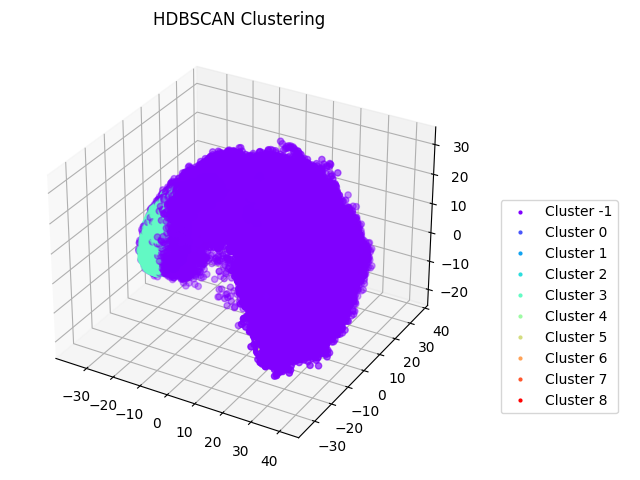

In [ ]:
from IPython.display import Image
display(Image(filename='faiss/clustering-example.png'))

Then we'll implement a FAISS database of the first 600,000 and then use this to predict the destination of the additional 100,000 images:

In [6]:
import numpy as np 
import pandas as pd
import faiss , sys
import gc

#change the individual rows into numpy arrays of type float32
db_vectors = [np.array(x, dtype="float32") for x in six_k_features ]

#change it from a list of arrays to an array of arrays.
db_vectors = np.array(db_vectors)

dimension = len(db_vectors[0])    # dimensions of each vector                         
n = len(db_vectors)    # number of vectors  

print(dimension,n)

nlist = int(9)  # number of clusters (see above image!)
quantiser = faiss.IndexFlatL2(dimension)  
index = faiss.IndexIVFFlat(quantiser, dimension, nlist,   faiss.METRIC_L2)

index.train(db_vectors)
index.add(db_vectors)

del db_vectors, six_k_features
gc.collect()

4096 600021


5

We have our index now, so we can search against it.

In [19]:
#change the individual rows into numpy arrays of type float32
search_vectors = [np.array(x, dtype="float32") for x in one_k_features[1:10000] ]

#change it from a list of arrays to an array of arrays.
search_vectors = np.array(search_vectors)

distances, indices = index.search(x=search_vectors,k=1)

print("done")

done


So if we call the clustered results the "truth" then we can measure the success of FAISS below - ignoring the "distances" for now.

In [21]:
with open("faiss-test/groupPickle.pickle","rb") as pickleFile:
        groups = pickle.load(pickleFile)

# this is one group per cluster with filenames as the value of the sub-list. we want this the other way round, to lookup target group from filename:
encodings = {file: group for group in groups for file in groups[group]}
#encodings is now a dictionary with the key as the filename and the value as the group as predicted by clustering.
successes = 0 
fails = 0
notfound = 0
failDetails = []

for i, idx in enumerate(indices.tolist()):
        try:
                matched_filename = six_k_filesList[idx[0]]
                predicted_group = encodings[matched_filename]
                actual_group = encodings[one_k_filesList[i]]
                if predicted_group == actual_group:
                        successes += 1
                else:
                        fails += 1
                        failDetails.append({"filename":one_k_filesList[i],"matched filename":matched_filename,"predicted group":predicted_group,
                                        "actual group":actual_group,"distance":distances[i]})
        except:
                notfound +=1

print(f"{fails+successes+notfound} matches checkd, {successes *100 / (fails+successes+notfound):.1f} % matches successful")

9999 matches checkd, 36.6 % matches successful


Comparing the two we see that the "correct" group was predicted 37% of the time
Getting the groups for all 700,000 took 111 seconds, while predicting the additional 100,000 groups took 50 minutes.

FAISS is therefor a poor solution for this, and only really feasible when we want to classify a very small number of new images that are being added to a very large existing dataset.

FAISS should be good at this. What went wrong?
Let's visualise some of the failed matches:

FileNotFoundError: [Errno 2] No such file or directory: 'Y:\\Allotment Timelapse\\2023-02-11\\130GOPRO\\G0027563.JPG'

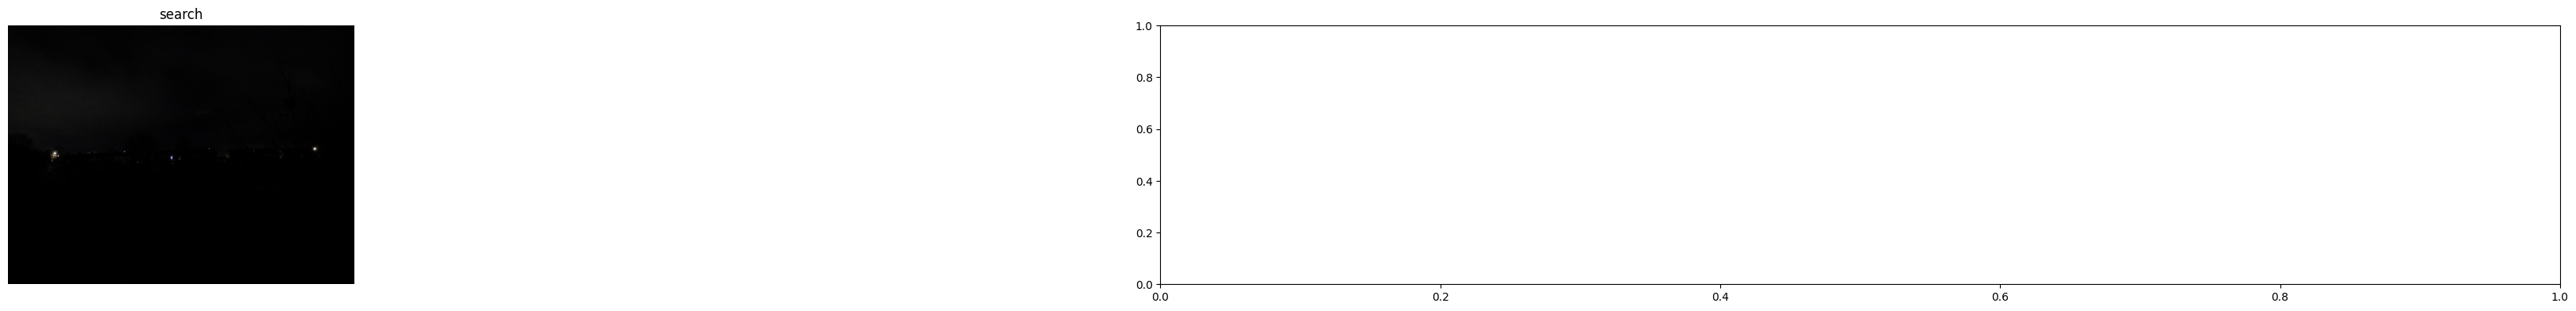

In [27]:
import random
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img 

fail_examples = random.sample(failDetails,k=8)


plt.figure(figsize = (50,50))

for index, fail in enumerate(fail_examples):
        plt.subplot(10,2,(index*2)+1)
        img = load_img(str(fail["filename"]).replace("D:\\Allotment Timelapse\\", "Y:\\Allotment Timelapse\\GoPro TimeLapse\\"))
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')
        plt.title("search")

        plt.subplot(10,2,(index*2)+2)
        img = load_img(str(fail["matched filename"]).replace("D:\\Allotment Timelapse\\", "Y:\\Allotment Timelapse\\GoPro TimeLapse\\"))
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')
        plt.title("found")


    
